# Data Analytics for Health - Task 2.2: Density-Based Clustering Analysis

## Overview
This notebook performs density-based clustering (DBSCAN) analysis on the prepared patient profile:
- 2.2.1: Study of the clustering parameters (eps and min_samples)
- 2.2.2: Characterization and interpretation of the obtained clusters

## Objectives
- Determine optimal DBSCAN parameters (eps and min_samples)
- Analyze cluster characteristics and identify noise points
- Interpret the density-based clustering results

---


In [69]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\Data
Plots directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\plots


## 1. Load Prepared Patient Profile


In [70]:
# Load prepared patient profile
df = pd.read_csv(data_path / 'patient_profile_broad_clean_clustering.csv')  

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")
df.info()

Loaded patient profile: 5,166 subjects × 25 features

Columns: ['subject_id', 'hadm_id', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']

Numeric features for clustering: 23
Features: ['is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density',

In [71]:
# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")


Numeric features for clustering: 23
Features: ['is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']


In [72]:
# maunally decrease featureset
#numeric_features = [c for c in numeric_features if c not in ['is_dead',  'abnormal_ratio', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'micro_qc_warn' , 'micro_qc_warn']]
#numeric_features = [c for c in numeric_features if c not in ['is_dead', ]]

In [91]:
X = df[numeric_features].copy()
# Create composite unique record id (subject_id + hadm_id) for mapping back results
df['record_id'] = df['subject_id'].astype(str) + '_' + df['hadm_id'].astype(str)
record_ids = df['record_id'].copy()

# Handle any remaining NaN values: NOTE is_Dead, abnormal_rat, qc_fail_ratio have some NaNs
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())  # Fill with mean or use appropriate strategy
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")


NaN values before handling: 0
NaN values after handling: 0

Data prepared for clustering: (5166, 23)


## 2.2.1 Study of the Clustering Parameters

### K-distance Graph for eps Selection


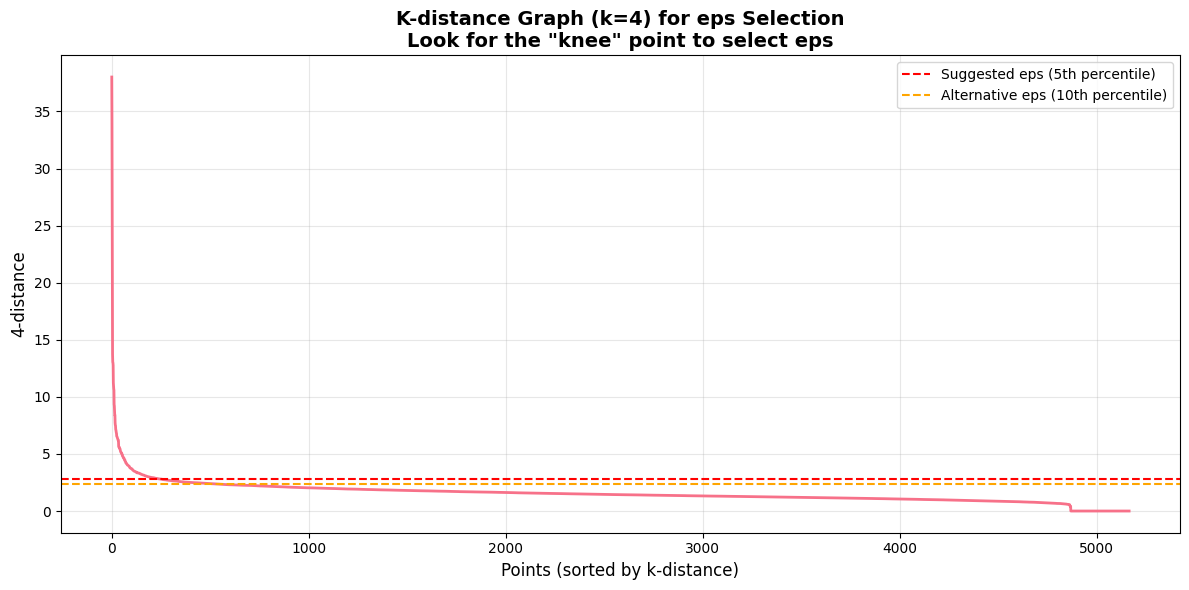

Suggested eps (5th percentile): 2.7613
Alternative eps (10th percentile): 2.3800


In [92]:
# Compute k-distances to help select eps parameter
# Use k = min_samples (typically 4 or 5 for DBSCAN)
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Get k-th nearest neighbor distances (k-distance)
k_distances = distances[:, k-1]
k_distances_sorted = np.sort(k_distances)[::-1]  # Sort in descending order

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2)
plt.xlabel('Points (sorted by k-distance)', fontsize=12)
plt.ylabel(f'{k}-distance', fontsize=12)
plt.title(f'K-distance Graph (k={k}) for eps Selection\nLook for the "knee" point to select eps', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=k_distances_sorted[int(len(k_distances_sorted) * 0.05)], 
           color='r', linestyle='--', label='Suggested eps (5th percentile)')
plt.axhline(y=k_distances_sorted[int(len(k_distances_sorted) * 0.1)], 
           color='orange', linestyle='--', label='Alternative eps (10th percentile)')
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / '2.2.1_k_distance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

suggested_eps = k_distances_sorted[int(len(k_distances_sorted) * 0.05)]
alt_eps = k_distances_sorted[int(len(k_distances_sorted) * 0.1)]
print(f"Suggested eps (5th percentile): {suggested_eps:.4f}")
print(f"Alternative eps (10th percentile): {alt_eps:.4f}")


### Parameter Grid Search: Testing Different eps and min_samples Values


In [75]:
# Test different combinations of eps and min_samples
eps_values = np.linspace(1.0, 7.0, 8)  # Adjust range based on k-distance graph
min_samples_values = [3, 4, 5, 6, 7]

param_results = []

print("Testing different parameter combinations...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Compute metrics only if we have at least 2 clusters
        if n_clusters >= 2:
            # Filter out noise points for metric computation
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 1:
                silhouette = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                davies_bouldin = davies_bouldin_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                calinski_harabasz = calinski_harabasz_score(X_scaled[non_noise_mask], labels[non_noise_mask])
            else:
                silhouette = -1
                davies_bouldin = np.inf
                calinski_harabasz = 0
        else:
            silhouette = -1
            davies_bouldin = np.inf
            calinski_harabasz = 0
        
        param_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz
        })
        
        print(f"eps={eps:.2f}, min_samples={min_samples}: "
              f"{n_clusters} clusters, {n_noise} noise ({noise_ratio:.1%}), "
              f"Silhouette={silhouette:.3f}")

param_df = pd.DataFrame(param_results)


Testing different parameter combinations...
eps=1.00, min_samples=3: 59 clusters, 3654 noise (70.7%), Silhouette=0.133
eps=1.00, min_samples=4: 36 clusters, 3813 noise (73.8%), Silhouette=0.183
eps=1.00, min_samples=5: 25 clusters, 3947 noise (76.4%), Silhouette=0.216
eps=1.00, min_samples=6: 17 clusters, 4046 noise (78.3%), Silhouette=0.292
eps=1.00, min_samples=7: 16 clusters, 4115 noise (79.7%), Silhouette=0.284
eps=1.86, min_samples=3: 12 clusters, 964 noise (18.7%), Silhouette=0.123
eps=1.86, min_samples=4: 8 clusters, 1022 noise (19.8%), Silhouette=0.367
eps=1.86, min_samples=5: 5 clusters, 1080 noise (20.9%), Silhouette=0.389
eps=1.86, min_samples=6: 4 clusters, 1124 noise (21.8%), Silhouette=0.398
eps=1.86, min_samples=7: 4 clusters, 1164 noise (22.5%), Silhouette=0.401
eps=2.71, min_samples=3: 6 clusters, 187 noise (3.6%), Silhouette=0.269
eps=2.71, min_samples=4: 3 clusters, 197 noise (3.8%), Silhouette=0.303
eps=2.71, min_samples=5: 3 clusters, 202 noise (3.9%), Silhouette=0

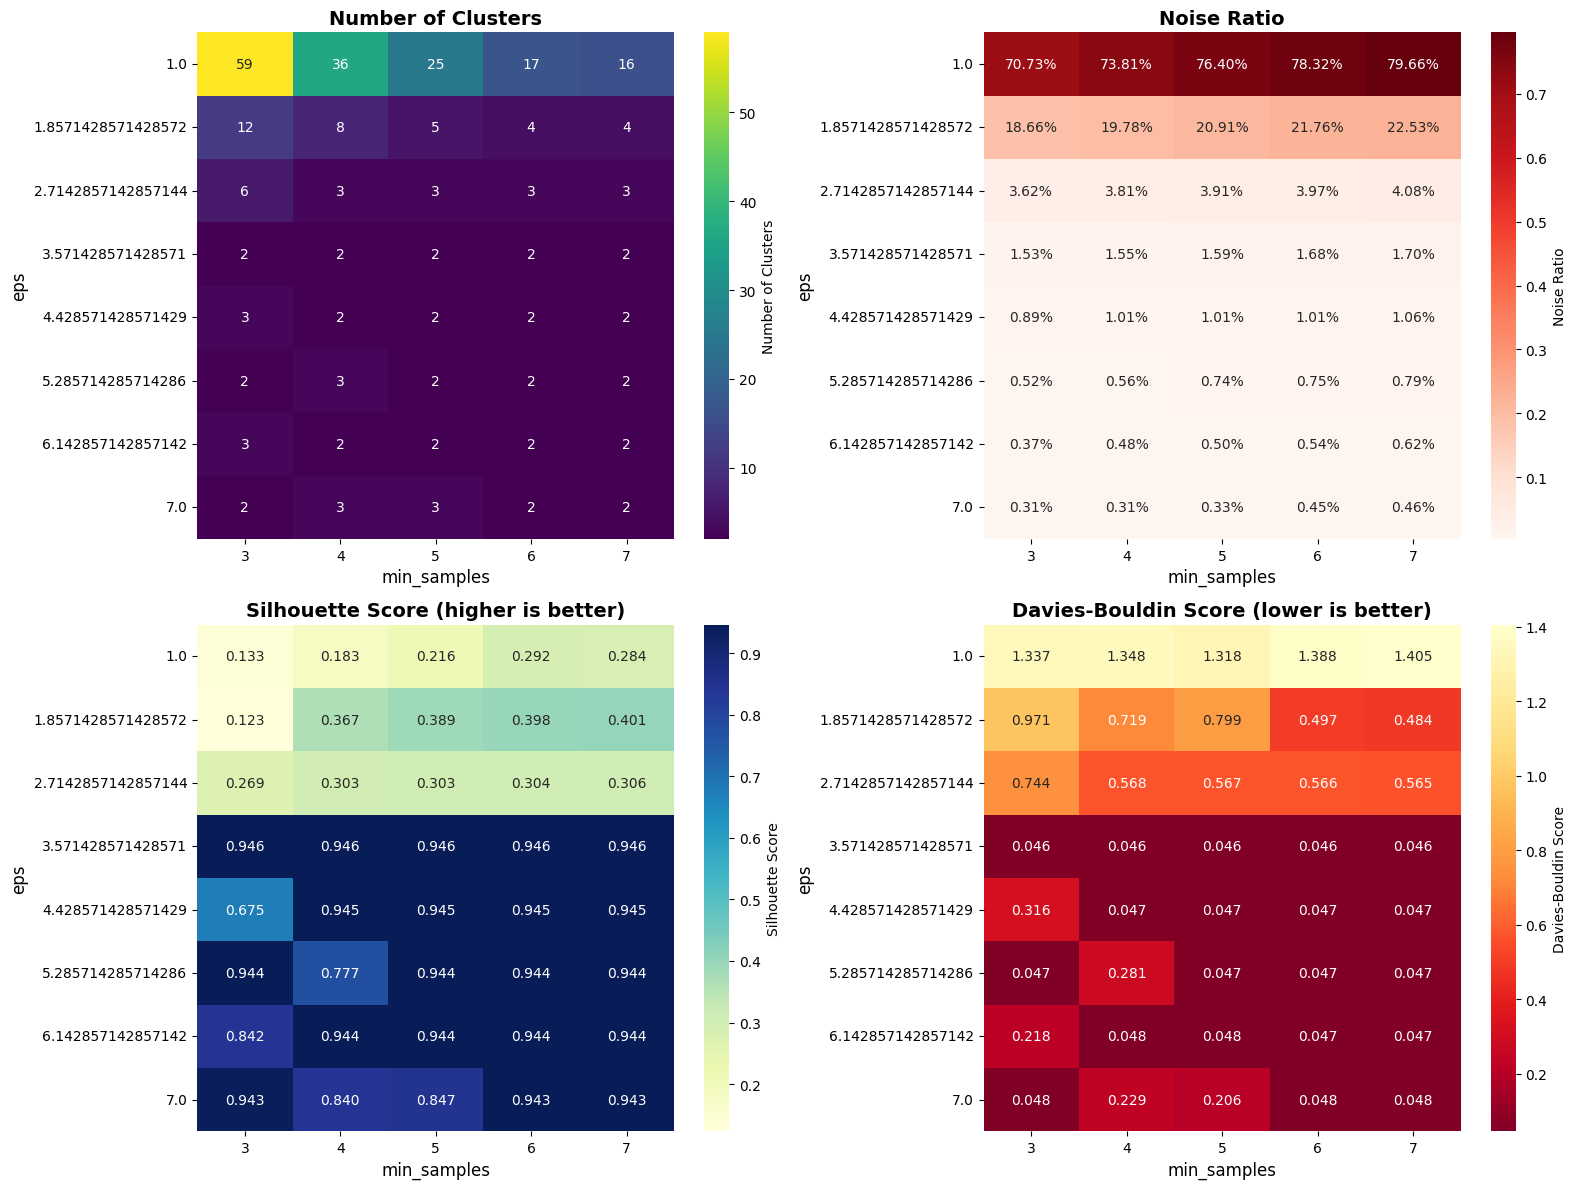

In [89]:
# Visualize parameter search results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Number of clusters
pivot_clusters = param_df.pivot(index='eps', columns='min_samples', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='viridis', ax=axes[0, 0], cbar_kws={'label': 'Number of Clusters'})
axes[0, 0].set_title('Number of Clusters', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('min_samples', fontsize=12)
axes[0, 0].set_ylabel('eps', fontsize=12)

# Noise ratio
pivot_noise = param_df.pivot(index='eps', columns='min_samples', values='noise_ratio')
sns.heatmap(pivot_noise, annot=True, fmt='.2%', cmap='Reds', ax=axes[0, 1], cbar_kws={'label': 'Noise Ratio'})
axes[0, 1].set_title('Noise Ratio', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('min_samples', fontsize=12)
axes[0, 1].set_ylabel('eps', fontsize=12)

# Silhouette score (only valid clusters)
pivot_sil = param_df.pivot(index='eps', columns='min_samples', values='silhouette')
pivot_sil = pivot_sil.replace(-1, np.nan)  # Replace invalid values
sns.heatmap(pivot_sil, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 0], 
           cbar_kws={'label': 'Silhouette Score'}, mask=pivot_sil.isna())
axes[1, 0].set_title('Silhouette Score (higher is better)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('min_samples', fontsize=12)
axes[1, 0].set_ylabel('eps', fontsize=12)

# Davies-Bouldin score
pivot_db = param_df.pivot(index='eps', columns='min_samples', values='davies_bouldin')
pivot_db = pivot_db.replace(np.inf, np.nan)
sns.heatmap(pivot_db, annot=True, fmt='.3f', cmap='YlOrRd_r', ax=axes[1, 1], 
           cbar_kws={'label': 'Davies-Bouldin Score'}, mask=pivot_db.isna())
axes[1, 1].set_title('Davies-Bouldin Score (lower is better)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('min_samples', fontsize=12)
axes[1, 1].set_ylabel('eps', fontsize=12)

plt.tight_layout()
plt.savefig(plots_dir / '2.2.1_parameter_search.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Find best parameters (balance between clusters, noise, and quality)
# Filter valid results (at least 2 clusters, reasonable noise ratio)
valid_results = param_df[(param_df['n_clusters'] >= 2) & (param_df['noise_ratio'] < 0.5)]

if len(valid_results) > 0:
    # Score based on silhouette (higher better) and noise ratio (lower better)
    valid_results['score'] = (valid_results['silhouette'] + 1) / 2 - valid_results['noise_ratio']
    best_params = valid_results.loc[valid_results['score'].idxmax()]
    
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
    
    print("="*80)
    print("OPTIMAL PARAMETERS")
    print("="*80)
    print(f"eps: {optimal_eps:.2f}")
    print(f"min_samples: {optimal_min_samples}")
    print(f"\nExpected results:")
    print(f"  Number of clusters: {int(best_params['n_clusters'])}")
    print(f"  Noise points: {int(best_params['n_noise'])} ({best_params['noise_ratio']:.1%})")
    print(f"  Silhouette score: {best_params['silhouette']:.3f}")
else:
    # Fallback: use suggested eps from k-distance graph
    optimal_eps = suggested_eps
    optimal_min_samples = 4
    print(f"Using default parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")

OPTIMAL PARAMETERS
eps: 7.00
min_samples: 3

Expected results:
  Number of clusters: 2
  Noise points: 16 (0.3%)
  Silhouette score: 0.943


In [108]:
# manually select optimal parameters
optimal_eps = 2.0
optimal_min_samples = 4
print(f"Using selected parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")

Using selected parameters: eps=2.00, min_samples=4


## 2.2.2 Characterization and Interpretation of the Obtained Clusters

### Perform Final DBSCAN Clustering


In [109]:
# Perform DBSCAN clustering with optimal parameters
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
cluster_labels = dbscan_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

# Analyze results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
noise_ratio = n_noise / len(cluster_labels)

print("="*80)
print("DBSCAN CLUSTERING RESULTS")
print("="*80)
print(f"Parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({noise_ratio:.1%})")
print(f"\nCluster distribution:")
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print(cluster_counts)

# Save clustered data
df_clustered.to_csv(data_path / '2.2_dbscan_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.2_dbscan_clustered_data.csv'}")


DBSCAN CLUSTERING RESULTS
Parameters: eps=2.00, min_samples=4
Number of clusters: 5
Noise points: 786 (15.2%)

Cluster distribution:
cluster
-1     786
 0    4060
 1       9
 2       5
 3       4
 4     302
Name: count, dtype: int64

Clustered data saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\Data\2.2_dbscan_clustered_data.csv


### Cluster Characteristics Analysis


Cluster Characteristics (Mean Values):
   cluster  size  is_dead  abnormal_ratio  qc_fail_ratio  fluid_diversity  \
0        0  4060     0.06             0.0           0.02             0.48   
1        1     9     0.00             0.0           0.00             0.00   
2        2     5     0.00             0.0           0.02             0.48   
3        3     4     0.00             0.0           0.02             0.55   
4        4   302     0.00             0.0           0.00             0.00   

   max_blood_sodium  num_intermediate  susceptible_ratio  micro_qc_fail  ...  \
0            140.97               0.0               0.03           0.06  ...   
1            141.00               0.0               0.00           0.00  ...   
2            140.40               0.0               0.00           0.00  ...   
3            147.00               0.0               0.06           1.50  ...   
4            141.00               0.0               0.24           0.05  ...   

   gender_F  clin

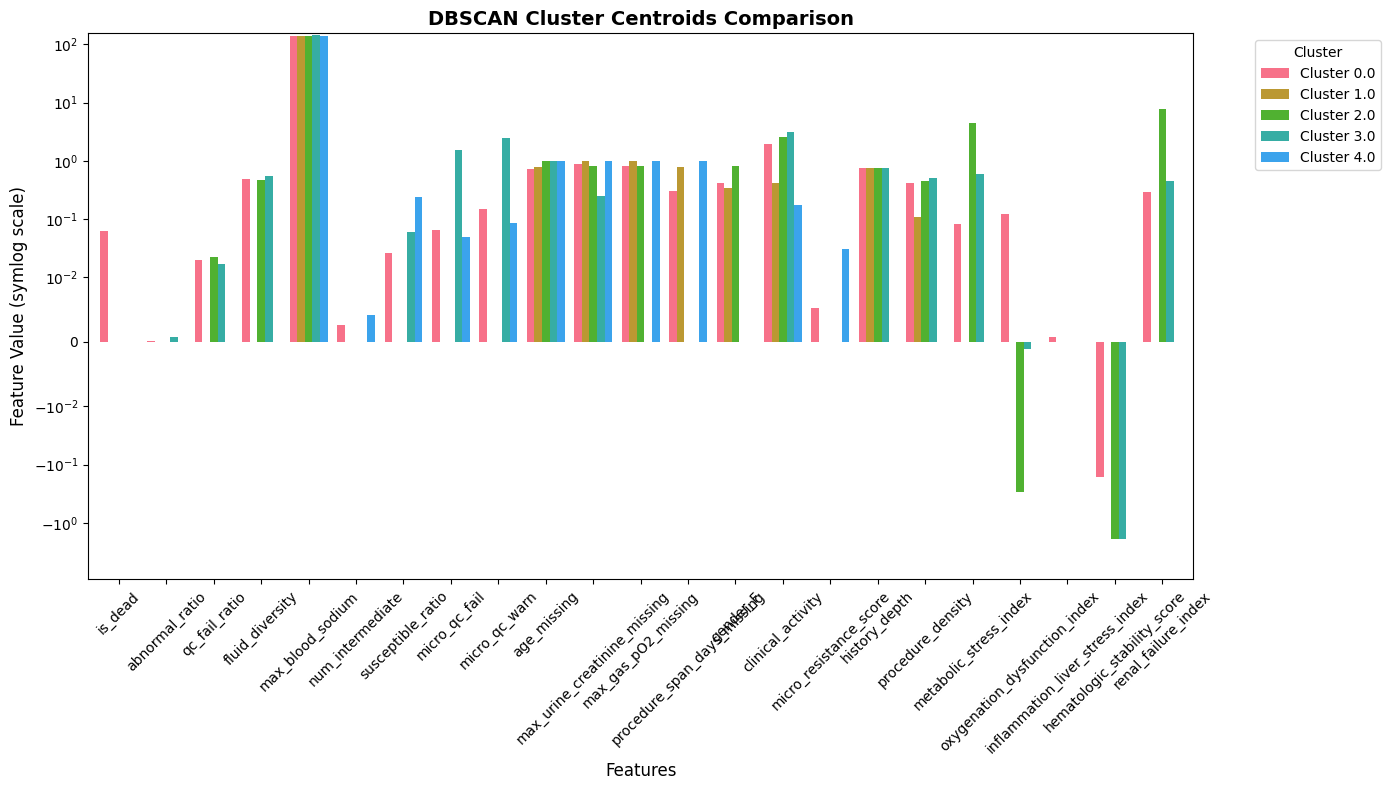

In [110]:
# Analyze cluster characteristics (excluding noise points)
valid_clusters = df_clustered[df_clustered['cluster'] != -1]

if len(valid_clusters) > 0:
    # Compute cluster statistics
    cluster_stats = []
    for cluster_id in sorted(valid_clusters['cluster'].unique()):
        cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id]
        
        stats = {'cluster': cluster_id, 'size': len(cluster_data)}
        for feature in numeric_features:
            stats[f'{feature}_mean'] = cluster_data[feature].mean()
            stats[f'{feature}_std'] = cluster_data[feature].std()
        
        cluster_stats.append(stats)
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Display mean values for each cluster
    print("Cluster Characteristics (Mean Values):")
    mean_cols = [col for col in cluster_stats_df.columns if col.endswith('_mean')]
    display_df = cluster_stats_df[['cluster', 'size'] + mean_cols].copy()
    display_df.columns = ['cluster', 'size'] + [col.replace('_mean', '') for col in mean_cols]
    print(display_df.round(2))
    
    # Visualize cluster centroids comparison
    centroid_data = []
    for cluster_id in sorted(valid_clusters['cluster'].unique()):
        cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id]
        centroid = cluster_data[numeric_features].mean()
        centroid['cluster'] = cluster_id
        centroid_data.append(centroid)
    
    centroids_df = pd.DataFrame(centroid_data)
    centroids_df = centroids_df.set_index('cluster')
    centroids_df.index = [f'Cluster {i}' for i in centroids_df.index]
    
    # Plot centroids
    fig, ax = plt.subplots(figsize=(14, 8))
    centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
    # Apply log scaling to y-axis (uses 'log' if all centroid values are > 0, else 'symlog')
    if np.all(centroids_df.values > 0):
        ax.set_yscale('log')
        y_label = 'Feature Value (log scale)'
    else:
        ax.set_yscale('symlog', linthresh=1e-2)
        y_label = 'Feature Value (symlog scale)'
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title('DBSCAN Cluster Centroids Comparison', fontsize=14, fontweight='bold')
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(plots_dir / '2.2.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No valid clusters found (all points are noise). Try adjusting parameters.")


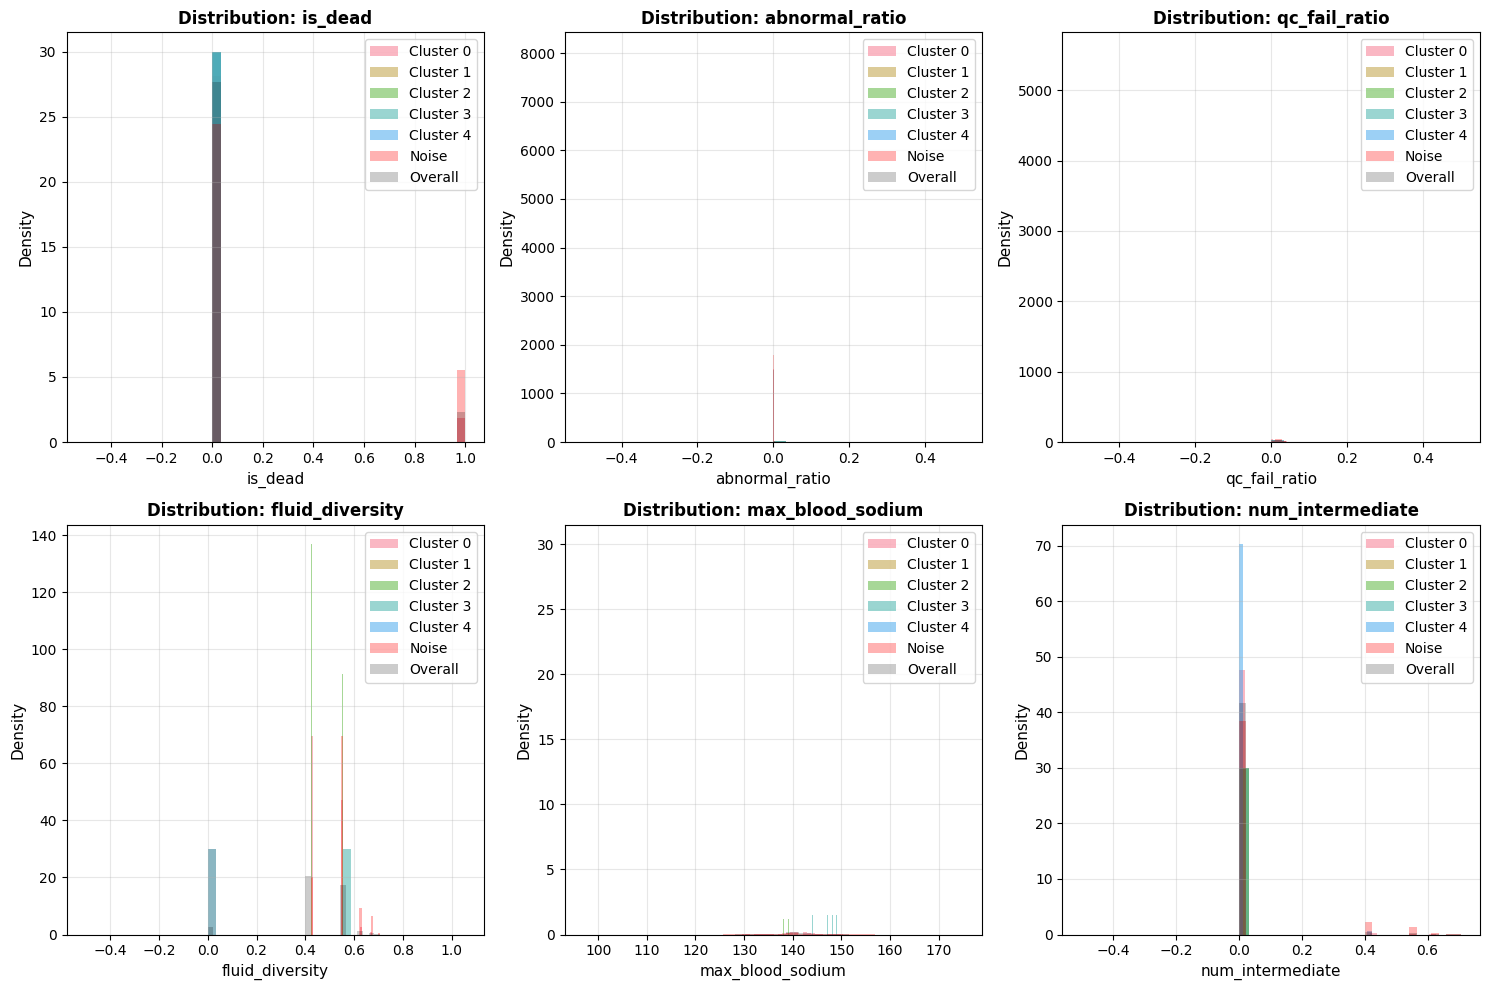

In [111]:
# Compare distributions: clusters vs overall vs noise
if len(valid_clusters) > 0:
    key_features = numeric_features[:6]  # Select first 6 features
    
    n_features = len(key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for idx, feature in enumerate(key_features):
        ax = axes[idx]
        
        # Plot distribution for each cluster
        for cluster_id in sorted(valid_clusters['cluster'].unique()):
            cluster_data = valid_clusters[valid_clusters['cluster'] == cluster_id][feature]
            ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
        
        # Plot noise points
        if n_noise > 0:
            noise_data = df_clustered[df_clustered['cluster'] == -1][feature]
            ax.hist(noise_data, alpha=0.3, color='red', label='Noise', bins=30, density=True, 
                   linestyle=':', linewidth=2)
        
        # Plot overall distribution
        ax.hist(df_clustered[feature], alpha=0.2, color='black', 
               label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
        
        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(plots_dir / '2.2.2_feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


### 2D Visualization using PCA


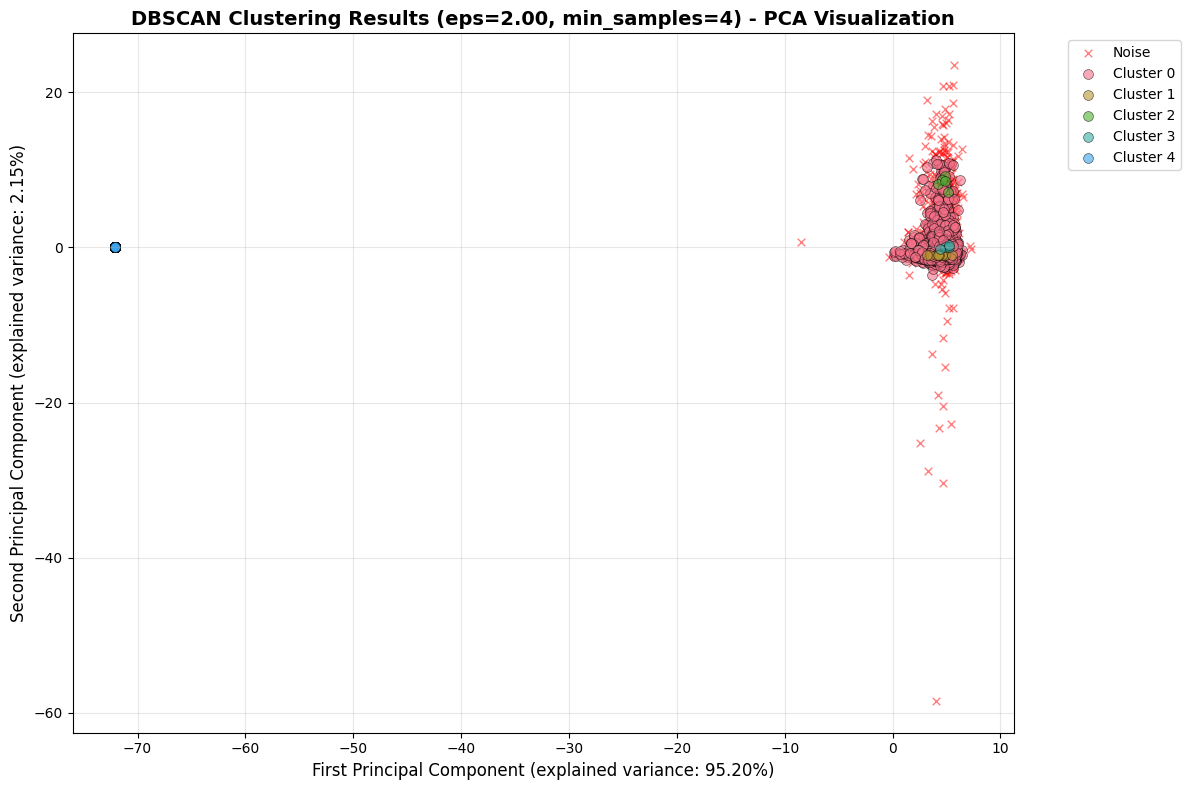

PCA explained variance ratio: [0.95200626 0.02148118]
Total explained variance: 97.35%


In [112]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot clusters
for cluster_id in sorted(df_clustered['cluster'].unique()):
    mask = cluster_labels == cluster_id
    if cluster_id == -1:
        # Noise points
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c='red', marker='x', s=30, alpha=0.5, label='Noise', linewidths=1)
    else:
        # Regular clusters
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  label=f'Cluster {cluster_id}', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'DBSCAN Clustering Results (eps={optimal_eps:.2f}, min_samples={optimal_min_samples}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plots_dir / '2.2.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")


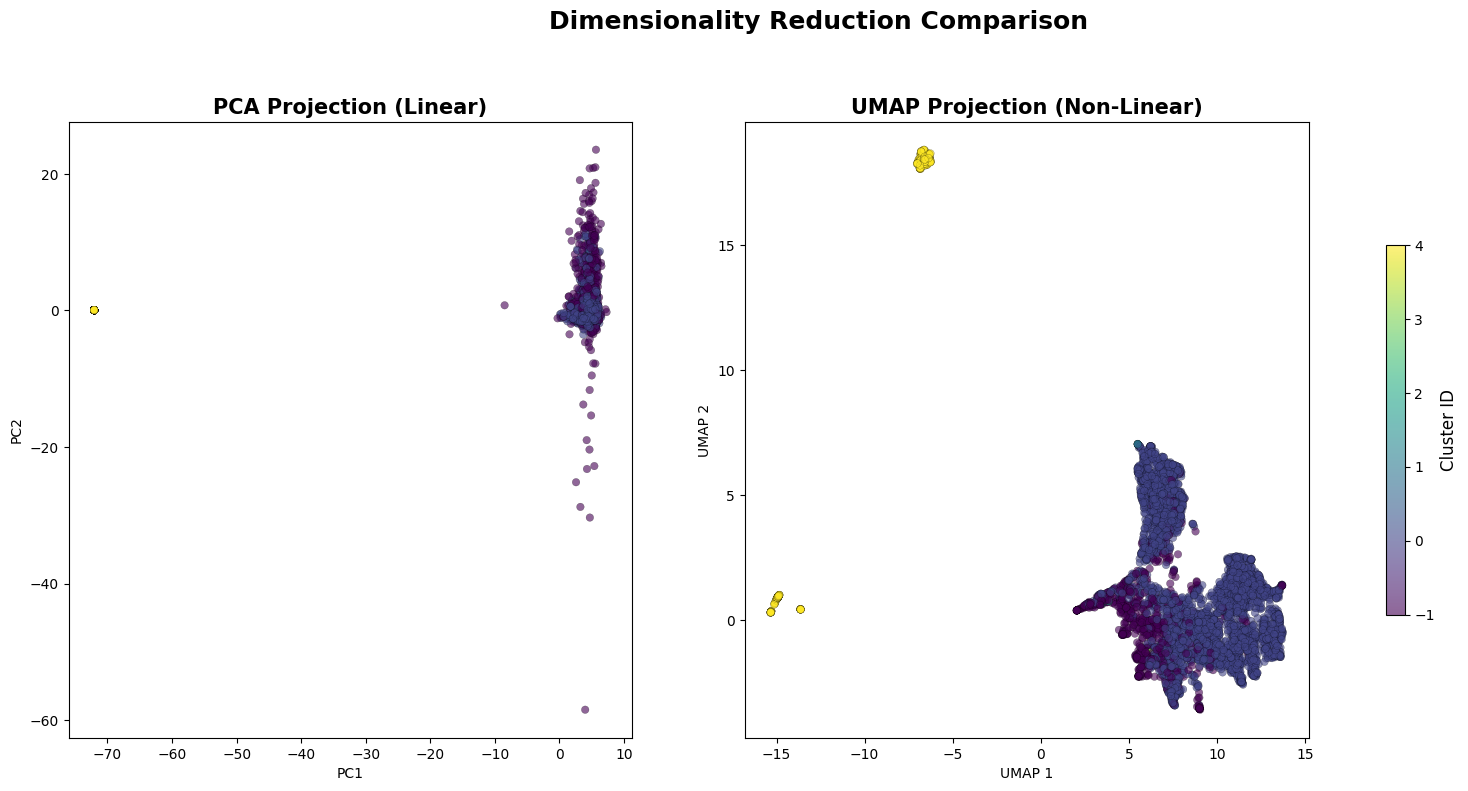

In [116]:
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize UMAP
# n_neighbors: low (5-20) focuses on local detail; high (50+) focuses on global structure
# min_dist: controls how tightly points are packed together
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 2. Re-run your PCA for the comparison
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Create Side-by-Side Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax1.set_title('PCA Projection (Linear)', fontsize=15, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot UMAP
scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax2.set_title('UMAP Projection (Non-Linear)', fontsize=15, fontweight='bold')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

# Add a shared colorbar
cbar = fig.colorbar(scatter2, ax=[ax1, ax2], location='right', shrink=0.6)
cbar.set_label('Cluster ID', fontsize=12)

plt.suptitle(f'Dimensionality Reduction Comparison', fontsize=18, fontweight='bold', y=1.02)
plt.savefig(plots_dir / '2.2.2_pca_vs_umap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [114]:
# Create a quick summary table of clinical outcomes
outcome_summary = df_clustered.groupby('cluster').agg({
    'is_dead': 'mean',
    'history_depth': 'mean',
    'metabolic_stress_index': 'mean',
    #'age': 'mean' # only if using the narrow profile
}).round(3)

print("Clinical Outcomes by Cluster:")
print(outcome_summary)

Clinical Outcomes by Cluster:
         is_dead  history_depth  metabolic_stress_index
cluster                                                
-1         0.184          0.761                   3.068
 0         0.062          0.760                   0.083
 1         0.000          0.762                   0.000
 2         0.000          0.762                   4.478
 3         0.000          0.764                   0.593
 4         0.000          0.000                   0.000


### Evaluation Metrics


In [115]:
# Compute evaluation metrics (excluding noise points)
if len(valid_clusters) >= 2:
    non_noise_mask = cluster_labels != -1
    non_noise_labels = cluster_labels[non_noise_mask]
    non_noise_X = X_scaled[non_noise_mask]
    
    silhouette_avg = silhouette_score(non_noise_X, non_noise_labels)
    davies_bouldin = davies_bouldin_score(non_noise_X, non_noise_labels)
    calinski_harabasz = calinski_harabasz_score(non_noise_X, non_noise_labels)
    
    print("="*80)
    print("DBSCAN CLUSTERING EVALUATION METRICS")
    print("="*80)
    print(f"Parameters: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Noise points: {n_noise} ({noise_ratio:.1%})")
    print(f"\nSilhouette Score: {silhouette_avg:.4f} (excluding noise)")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f} (excluding noise)")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f} (excluding noise)")
else:
    print("Not enough clusters for evaluation metrics (need at least 2 clusters)")


DBSCAN CLUSTERING EVALUATION METRICS
Parameters: eps=2.00, min_samples=4
Number of clusters: 5
Noise points: 786 (15.2%)

Silhouette Score: 0.2594 (excluding noise)
Davies-Bouldin Score: 0.6329 (excluding noise)
Calinski-Harabasz Score: 58933.4233 (excluding noise)


## Summary and Conclusions

### Key Findings:
1. **Optimal Parameters**: Selected eps and min_samples based on k-distance graph and grid search
2. **Cluster Characteristics**: Each cluster shows distinct density-based patterns
3. **Noise Points**: Identified outliers that don't belong to any dense cluster
4. **Evaluation**: Clustering quality assessed using standard metrics

### Advantages of DBSCAN:
- Can identify clusters of arbitrary shape
- Automatically determines number of clusters
- Identifies noise/outlier points
- Robust to outliers